In [1]:
# Import relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit
from tqdm import tqdm

In [3]:
# Function to load in data from an excel file

def load_excel(file_path, sheet_name='data'):
    # Load the Excel file into a DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # Rename columns in pairs
    sample_names = []
    new_columns = []
    for i in range(0, len(df.columns), 2):
        base_name = df.columns[i]
        sample_names.append(base_name)
        new_columns.append(f"{base_name} Raman Shift")
        new_columns.append(f"{base_name} Intensity")

    # Apply the new column names to the DataFrame
    df.columns = new_columns

    # Drop the first row and reset index
    df = df.drop(index=0).reset_index(drop=True)

    return df, sample_names

In [5]:
# Function to visualise the Raman spectra stacked in a single figure

import matplotlib.pyplot as plt

def plot_spectra_stack(df, num_spectra=None, columns=None):
    """
    Plots stacked spectra from a DataFrame with control over the number of spectra or specific columns to plot.

    Parameters:
    - df: DataFrame containing spectral data in pairs of columns.
    - num_spectra: int, optional, number of spectra (pairs of columns) to plot. Defaults to all pairs if None.
    - columns: list, optional, specific list of column names to plot (overrides num_spectra if provided).
    
    Returns:
    - fig: The Matplotlib figure object containing the plot.
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 18))
    
    # Determine columns to plot based on user input
    if columns is not None:
        # Use specific columns if provided
        selected_columns = columns
    else:
        # If num_spectra is not provided, use the entire DataFrame
        max_pairs = len(df.columns) // 2
        num_spectra = num_spectra or max_pairs  # Default to all pairs if num_spectra is None
        selected_columns = df.columns[:2 * num_spectra]

    # Iterate over each pair of selected columns and plot with an offset
    for i in range(0, len(selected_columns), 2):
        x = df[selected_columns[i]]      # Select x data
        y = df[selected_columns[i + 1]]  # Select corresponding y data
    
        # Filter data to include only x values above 1000
        mask = x > 1000
        x_filtered = x[mask]
        y_filtered = y[mask]
    
        # Plot the filtered data with an offset for stacking
        label = sample_names[i // 2] if i // 2 < len(sample_names) else f"Spectrum {i // 2 + 1}"
        ax.plot(x_filtered, y_filtered + (i // 2) * 10, label=label)

    # Set labels and legend
    ax.set_xlabel("Raman Shift (cm$^{-1}$)")
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0., frameon=False)
    
    # Remove y-axis ticks and labels
    ax.yaxis.set_visible(False)
    
    # Adjust layout to make room for the legend
    fig.tight_layout()
    
    # Return the figure object for further use
    return fig

In [7]:
# Defining peak fitting functions

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def pseudo_voigt(x, A, mu, sigma, eta):
    # Gaussian component
    gaussian = A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    # Lorentzian component
    lorentzian = A * (sigma ** 2) / ((x - mu) ** 2 + sigma ** 2)
    # Combined Pseudo-Voigt profile
    return eta * lorentzian + (1 - eta) * gaussian

def multiple_peaks(x, *params):
    y = 0
    for i in range(0, len(params), 3):
        A, mu, sigma = map(float, params[i:i+3])  # Convert each parameter to float explicitly

        # Ensure sigma is not zero or too close to zero
        if sigma < 1e-10:
            #print("Warning: sigma is too small, adjusting to avoid division by zero.")
            sigma = 1e-10

        # Convert x to a float array, if not already
        x = np.asarray(x, dtype=float)

        # Perform the Gaussian calculation
        y += A * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return y

In [9]:
# Defining spectra processing and fitting

def process_spectra(df, prominence=0.01, baseline_lambda=1e5, window_length=101, polyorder=3):
    
    """
    Processes multiple spectra in a DataFrame, applies baseline correction, smooths, normalizes, 
    and fits peaks using a Pseudo-Voigt profile.

    Parameters:
    - df: pd.DataFrame, DataFrame containing spectral data in pairs of columns.
    - prominence: float, prominence threshold for peak detection.
    - baseline_lambda: float, parameter for baseline correction.
    - window_length: int, window length for Savitzky-Golay filter.
    - polyorder: int, polynomial order for Savitzky-Golay filter.

    Returns:
    - df_dict: dict, dictionary with sample names as keys and DataFrames with peak data as values.
    - fig_dict: dict, dictionary with sample names as keys and corresponding figures as values.
    """
    
    # Initialise empty lists to store dataframes and figures
    list_peakdf = []
    figures = []

    for i in tqdm(range(0, len(df.columns), 2), desc="Processing Spectra"):
        
        sample_name = df.columns[i]

        # Convert to numeric and drop non-numeric values
        x = df.iloc[:, i].dropna()
        y = df.iloc[:, i + 1].dropna()

        y_list = y.to_list()

        # Initialize the Baseline class
        baseline_obj = Baseline()

        # Baseline correction
        try:
            baseline, params = baseline_obj.iarpls(y_list, baseline_lambda)
            corrected_y = y - baseline
        except ValueError as e:
            print(f"Skipping pair {i//2 + 1} due to error: {e}")
            continue

        # Smoothing and normalization
        y_smoothed = savgol_filter(corrected_y, window_length=window_length, polyorder=polyorder)
        y_sn = (y_smoothed - np.min(y_smoothed)) / (np.max(y_smoothed) - np.min(y_smoothed))

        # Peak finding
        peaks, _ = find_peaks(y_sn, prominence=prominence)
        peak_positions = x[peaks]

        # Create initial guesses for each peak
        initial_guesses = []
        for peak_position in peak_positions:
            initial_guesses.extend([np.max(y_sn[np.abs(x - peak_position) < 50]), peak_position, 10])

        # Skip this iteration if no peaks are detected
        if not initial_guesses:
            print("No peaks detected. Please adjust the prominence threshold or check your data.")
            continue

        # Convert x to a numpy array for fitting
        x_array = x.to_numpy()

        # Define bounds for fitting
        lower_bounds = [0, min(x_array), 1] * (len(initial_guesses) // 3)
        upper_bounds = [np.max(y_sn), max(x_array), 100] * (len(initial_guesses) // 3)

        # Fit the multiple peaks
        try:
            popt, pcov = curve_fit(multiple_peaks, x_array, y_sn, initial_guesses, 
                                   bounds=(lower_bounds, upper_bounds), maxfev=100000)
        except Exception as e:
            print(f"An error occurred during curve fitting: {e}")
            continue

        # Generate the fitted curve
        y_fit = multiple_peaks(x_array, *popt)

        # Plot the data, fitted curve, and mark peaks
        fig, ax = plt.subplots()
        ax.plot(x, y_sn, label='Data')
        ax.plot(x, y_fit, label='Fit')

        # Mark the detected peaks on the plot
        for peak_pos in peak_positions:
            ax.axvline(x=peak_pos, color='black', linestyle='-', alpha=0.7)
            ax.text(peak_pos + 10, np.max(y_sn), f"{peak_pos:.0f}", 
                va='center', ha='left', color='black', fontsize=8)

        # Add labels and legend
        ax.set_xlabel("Raman Shift (cm$^{-1}$)")
        ax.set_ylabel("Intensity (a.u.)")
        ax.legend()

        # Store the figure and close it to prevent immediate display
        figures.append(fig)
        plt.close(fig)

        # Extract peak information
        peak_data = []
        for j in range(len(popt) // 3):
            peak_data.append({
                "Peak Number": j + 1,
                "Center Raman Shift": popt[j*3 + 1],
                "Intensity Amplitude": popt[j*3],
                "Standard Deviation": popt[j*3 + 2]
            })

        # Create a DataFrame from peak data
        peakdf = pd.DataFrame(peak_data)

        # Calculating integrated intensities
        integrated_intensities = []
        for j in range(len(popt) // 3):
            A, mu, sigma = popt[j*3 : j*3+3]
            integrated_intensity = A * sigma * np.sqrt(2 * np.pi)
            integrated_intensities.append(integrated_intensity)
        
        # Add integrated intensities to the DataFrame
        peakdf['Integrated Intensity'] = integrated_intensities

        # Sort by intensity
        peakdf_sorted = peakdf.sort_values(by="Intensity Amplitude", ascending=False).reset_index(drop=True)
        list_peakdf.append(peakdf_sorted)

    # Create dictionaries for DataFrames and figures
    df_dict = dict(zip(sample_names, list_peakdf))
    fig_dict = dict(zip(sample_names, figures))

    return df_dict, fig_dict

In [11]:
# Loading in Raman spectroscopy data from excel file

file_path = 'intensity_data.xlsx'

df, sample_names = load_excel(file_path, sheet_name='data')
df

,CE_PIM_Pd8wt_LIG Raman Shift,CE_PIM_Pd8wt_LIG Intensity,CE_PIM_Pd4wt_LIG Raman Shift,CE_PIM_Pd4wt_LIG Intensity,CE_PIM_Pd2wt_LIG Raman Shift,CE_PIM_Pd2wt_LIG Intensity,CE_PIM_Pd1wt_LIG Raman Shift,CE_PIM_Pd1wt_LIG Intensity,CE_PIM_Zn1wt_LIG Raman Shift,CE_PIM_Zn1wt_LIG Intensity,...,CE_1per_3W_333ppi_LIG Raman Shift,CE_1per_3W_333ppi_LIG Intensity,CE_1per_3-5W_1000ppi_LIG Raman Shift,CE_1per_3-5W_1000ppi_LIG Intensity,CE_1per_3-5W_333ppi_LIG Raman Shift,CE_1per_3-5W_333ppi_LIG Intensity,2_LIG Raman Shift,2_LIG Intensity,_LIG Raman Shift,_LIG Intensity
0,3200.17,-0.110966,3200.17,-0.160609,3200.14,-0.257574,3200.14,-0.105446,3200.15,0.451541,...,3200.23,0.080267,3200.23,-0.309086,3200.23,-0.142239,3200.25,-0.431111,3200.25,-0.441426
1,3199.38,-0.104012,3199.38,-0.112895,3199.35,-0.217782,3199.35,-0.087468,3199.36,0.491584,...,3199.43,-0.474085,3199.43,-0.682637,3199.43,-0.291804,3199.46,-0.52937,3199.46,-0.353542
2,3198.59,-0.124296,3198.59,-0.088512,3198.56,-0.194627,3198.56,-0.05554,3198.56,0.532761,...,3198.64,0.215778,3198.64,-0.413167,3198.64,-0.224339,3198.67,-0.474161,3198.67,-0.490392
3,3197.8,-0.150435,3197.8,-0.139342,3197.77,-0.180511,3197.77,-0.04925,3197.77,0.521549,...,3197.85,-1.394194,3197.85,-0.358244,3197.85,-0.633941,3197.88,-0.521305,3197.88,-0.29039
4,3197,-0.138989,3197,-0.131933,3196.98,-0.196598,3196.98,-0.086657,3196.98,0.462222,...,3197.06,0.289079,3197.06,-0.249728,3197.06,-0.566441,3197.08,-0.41546,3197.08,-0.34358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,104.125,3.158338,3.028688,0.317764
3111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,102.884,3.199674,3.018483,0.315288
3112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101.643,3.094052,3.007691,0.312837
3113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.402,3.119091,2.996324,0.31041


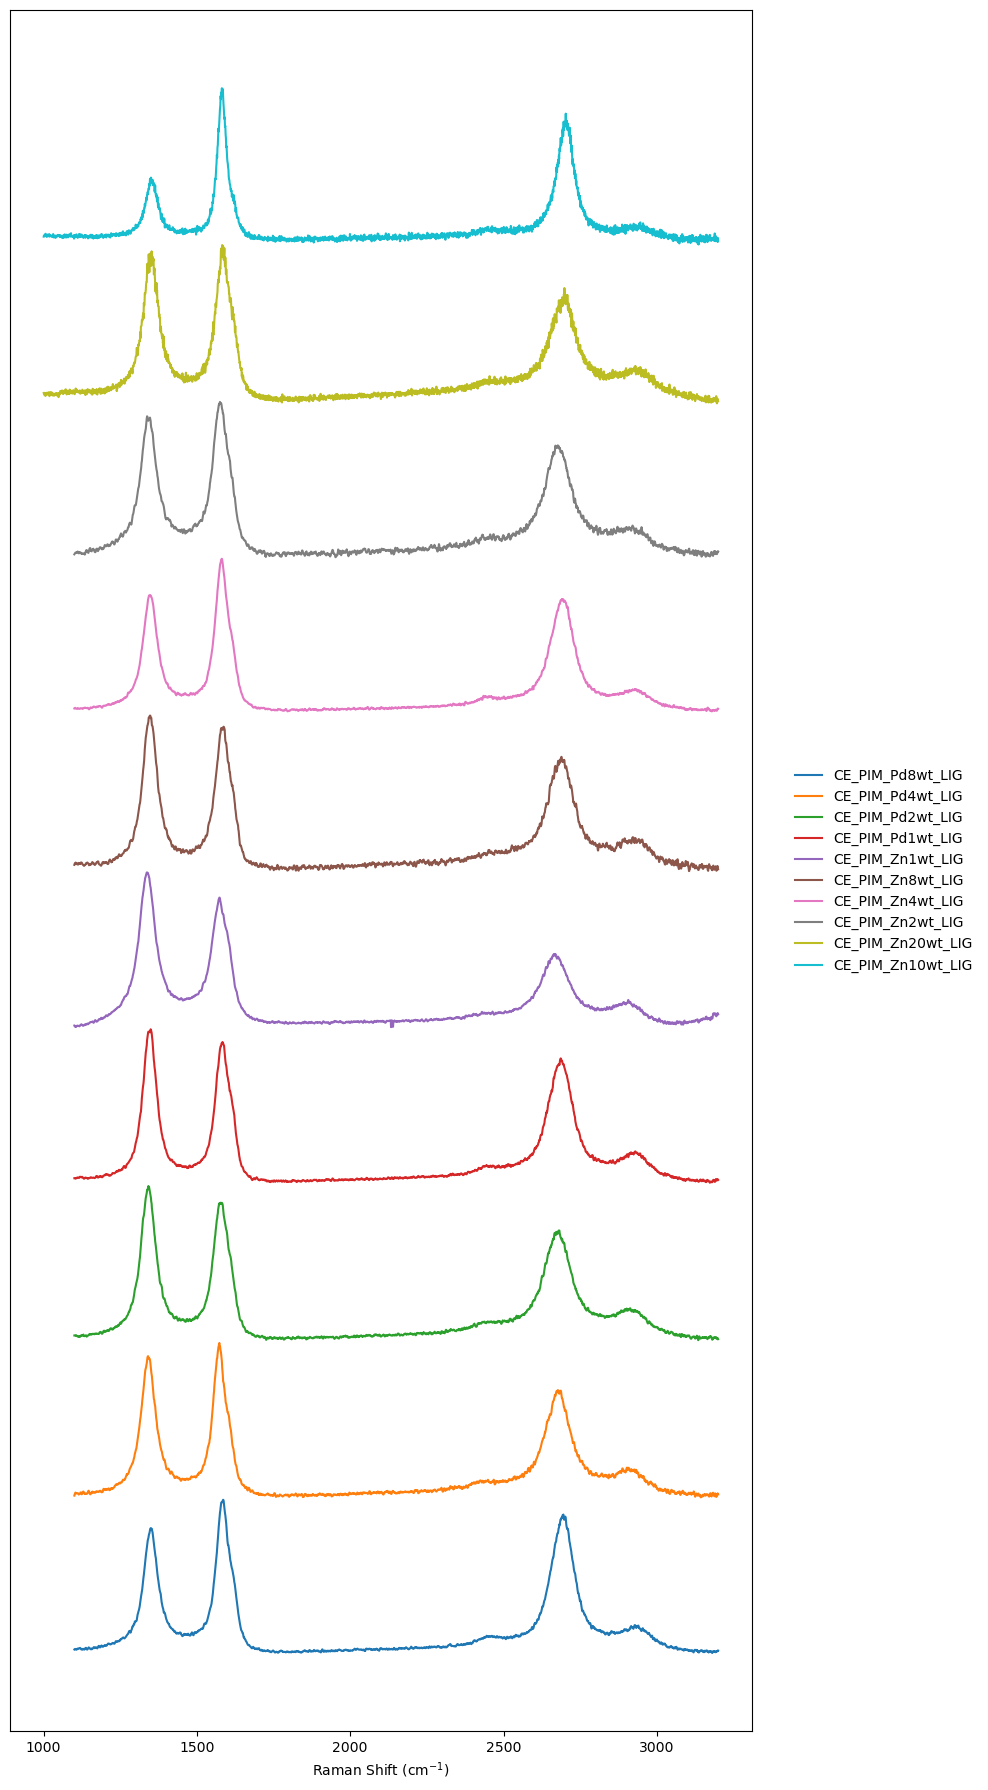

In [13]:
# Call the stack plotting function

stack = plot_spectra_stack(df, num_spectra=10)

# Save the figure
stack.savefig("stack_spectrum.png", dpi=300, bbox_inches="tight")

In [15]:
# Call the process spectra function to fit the Raman spectroscopy data and identify peak positions

df_dict, fig_dict = process_spectra(df, prominence=0.01, baseline_lambda=1e5, window_length=101, polyorder=3)

Processing Spectra: 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]


In [17]:
# Checking the result

# Replace key to change sample
Sample = 'CE_PIM_Pd1wt_LIG'
df_sample = df_dict.get(Sample)
df_sample

,Peak Number,Center Raman Shift,Intensity Amplitude,Standard Deviation,Integrated Intensity
0,5,1345.489490,1.000000,29.050993,72.820041
1,4,1586.099766,0.986707,30.184254,74.654969
2,2,2685.295046,0.817247,39.197893,80.298188
3,1,2933.138323,0.123102,35.613218,10.989234
4,3,2441.079565,0.034313,32.007724,2.752964


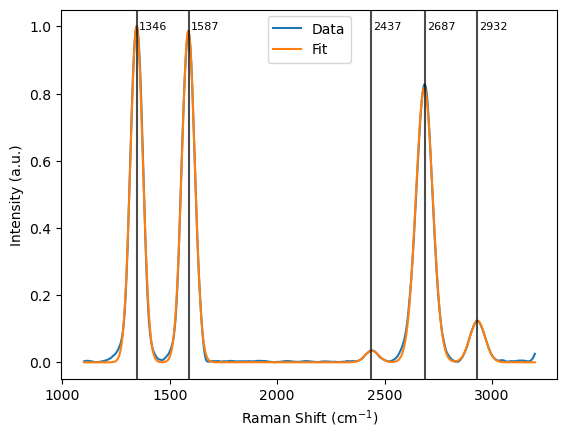

In [19]:
# Checking the result

# Replace key to change sample
Sample = 'CE_PIM_Pd1wt_LIG'
spectrum_fit = fig_dict.get(Sample)
spectrum_fit

# Save the figure
#spectrum_fit.savefig("spectrum_fit.png", dpi=300, bbox_inches="tight")